In [1]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Print GPU details
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print("GPU Device:", gpu_devices[0])
else:
    print("No GPU found!")


Num GPUs Available: 1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
"""import zipfile
import os

zip_path = "/content/uploading.zip"  # Path where you copied the file
extract_path = "/content/"  # Folder where it will be 
extracted

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
os.listdir(extract_path)
"""



'import zipfile\nimport os\n\nzip_path = "/content/uploading.zip"  # Path where you copied the file\nextract_path = "/content/"  # Folder where it will be \nextracted\n\n# Unzipping the dataset\nwith zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n    zip_ref.extractall(extract_path)\n\n# Verify extraction\nos.listdir(extract_path)\n'

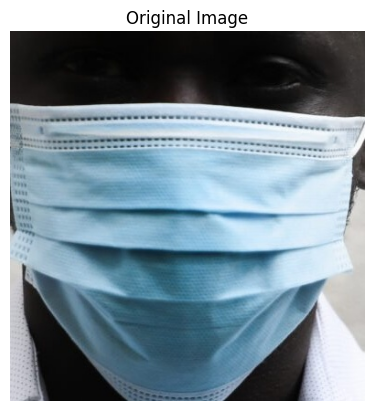

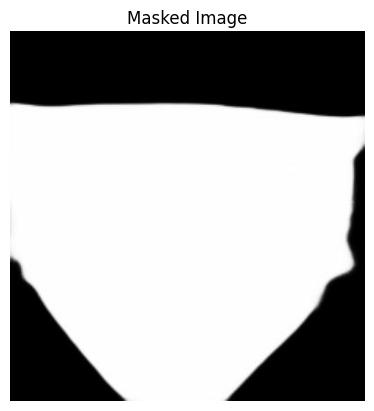

Original Image shape:  (405, 388, 3)
Masked Image shape:  (405, 388, 3)
Original path Image size: 0.04 MB
Masked path Image size: 0.01 MB


In [3]:
import matplotlib.pyplot as plt
import cv2
import os

# Ensure the paths are correct and the files exist:
original_path = "/kaggle/input/face-mask-seg2/uploading/face_crop/000000_1.jpg"
masked_path = "/kaggle/input/face-mask-seg2/uploading/face_crop_segmentation/000000_1.jpg"

# Check if the files exist and handle errors if they don't
if not os.path.exists(original_path):
    raise FileNotFoundError(f"Image file not found: {original_path}")
if not os.path.exists(masked_path):
    raise FileNotFoundError(f"Mask file not found: {masked_path}")

# Load images using cv2.imread
original = cv2.imread(original_path)
masked = cv2.imread(masked_path)

# Check if images were loaded successfully
if original is None:
    raise ValueError(f"Could not load image: {original_path}")
if masked is None:
    raise ValueError(f"Could not load mask: {masked_path}")

# Continue with displaying the images
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for plt.imshow
plt.title("Original Image")
plt.axis("off")
plt.show()

plt.imshow(masked)  # Masked image is likely already in a suitable format
plt.title("Masked Image")
plt.axis("off")
plt.show()

print("Original Image shape: ", original.shape)
print("Masked Image shape: ", masked.shape)


import os

 # Change this to your image path
file_size = os.path.getsize(original_path)  # Size in bytes
file_size_mb = file_size / (1024 * 1024)  # Convert to MB
print(f"Original path Image size: {file_size_mb:.2f} MB")


file_size = os.path.getsize(masked_path)
file_size_mb = file_size / (1024 * 1024)

print(f"Masked path Image size: {file_size_mb:.2f} MB")




In [4]:
!pip install tensorflow
!pip install keras-tuner
!pip install graphviz pydot
!apt-get install -y graphviz
!pip install pydot


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 129 not upgraded.


In [ ]:
# -------------------------------
# Install Dependencies FIRST
# -------------------------------
!apt-get install graphviz -qq
!pip install pydot pydotplus --quiet
import os
os.environ["PATH"] += os.pathsep + "/usr/bin/graphviz"

# -------------------------------
# Imports
# -------------------------------
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from skimage.filters import threshold_otsu
from io import StringIO
import itertools
import sys

# -------------------------------
# Custom Metrics (Fixed)
# -------------------------------
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    score = (intersection + smooth) / (union + smooth)
    return tf.where(tf.math.is_nan(score), 0.0, score)
iou_metric.__name__ = 'iou_metric'

def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return tf.where(tf.math.is_nan(score), 0.0, score)
dice_metric.__name__ = 'dice_metric'

# -------------------------------
# Enhanced Data Generator
# -------------------------------
class PairedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_generator, mask_generator):
        self.image_generator = image_generator
        self.mask_generator = mask_generator
        assert len(image_generator) == len(mask_generator)
        
    def __len__(self):
        return len(self.image_generator)
    
    def __getitem__(self, index):
        x = self.image_generator[index]
        y = self.mask_generator[index]
        return x, y
    
    def on_epoch_end(self):
        self.image_generator.on_epoch_end()
        self.mask_generator.on_epoch_end()

# -------------------------------
# Robust U-Net Trainer Class
# -------------------------------
class UNetSegmentationTrainer:
    def __init__(self, image_dir, mask_dir, output_csv="results/model_results.csv",
                 plot_folder="results/model_plots", summary_folder="results/model_summaries",
                 best_model_path="results/best_model.h5",
                 image_size=(128, 128), batch_size=8, epochs=5, validation_split=0.2):
        
        # Validate inputs and create directories
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Image directory not found: {image_dir}")
        if not os.path.exists(mask_dir):
            raise FileNotFoundError(f"Mask directory not found: {mask_dir}")
        
        os.makedirs(plot_folder, exist_ok=True)
        os.makedirs(summary_folder, exist_ok=True)
        os.makedirs(os.path.dirname(best_model_path), exist_ok=True)

        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.epochs = epochs
        self.validation_split = validation_split
        self.best_model_path = best_model_path
        self.output_csv = output_csv
        self.plot_folder = plot_folder
        self.summary_folder = summary_folder

        # Initialize data augmentation
        self._init_augmentations()
        
        # Initialize results dataframe with correct columns
        self.results_df = pd.DataFrame(columns=[
            "trial_id", "learning_rate", "dropout", "num_filters", "kernel_size",
            "val_iou", "val_dice", "plot_path", "summary_path"
        ])

    def _init_augmentations(self):
        self.data_gen_args = {
            'rotation_range': 10,
            'width_shift_range': 0.1,
            'height_shift_range': 0.1,
            'shear_range': 0.1,
            'zoom_range': 0.1,
            'horizontal_flip': True,
            'fill_mode': 'nearest'
        }
        
        self.image_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=self.validation_split,
            **self.data_gen_args
        )
        
        self.mask_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=self.validation_split,
            **self.data_gen_args
        )

    def load_data(self):
        print("load_data function")
        def load_images(dir_path, color_mode=cv2.IMREAD_COLOR):
            print("Load_images function\n")
            files = sorted([f for f in os.listdir(dir_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            images = []
            for f in files:
                img = cv2.imread(os.path.join(dir_path, f), color_mode)
                if img is None:
                    raise ValueError(f"Failed to read image: {f}")
                img = cv2.resize(img, self.image_size)
                if color_mode == cv2.IMREAD_GRAYSCALE:
                    img = np.expand_dims(img, axis=-1)
                images.append(img)
            return np.array(images), files
        
        images, img_files = load_images(self.image_dir)
        masks, mask_files = load_images(self.mask_dir, cv2.IMREAD_GRAYSCALE)
        
        if len(img_files) != len(mask_files):
            raise ValueError("Mismatched image/mask counts")
        for img, mask in zip(img_files, mask_files):
            if img != mask:
                raise ValueError(f"Filename mismatch: {img} vs {mask}")

        return images, masks

    def get_data_generators(self, images, masks):
        print("get data generator\n")
        train_image_gen = self.image_datagen.flow(
            images, batch_size=self.batch_size,
            subset='training', seed=42, shuffle=True
        )
        train_mask_gen = self.mask_datagen.flow(
            masks, batch_size=self.batch_size,
            subset='training', seed=42, shuffle=True
        )
        val_image_gen = self.image_datagen.flow(
            images, batch_size=self.batch_size,
            subset='validation', seed=42, shuffle=False
        )
        val_mask_gen = self.mask_datagen.flow(
            masks, batch_size=self.batch_size,
            subset='validation', seed=42, shuffle=False
        )

        return (
            PairedDataGenerator(train_image_gen, train_mask_gen),
            PairedDataGenerator(val_image_gen, val_mask_gen)
        )

    def build_unet_model(self, params):
        print("Build model unet\n")
        """Build model from parameter dictionary"""
        inputs = layers.Input(shape=(*self.image_size, 3))
        
        # Architecture parameters
        base_filters = params['num_filters']
        depth = 3  # Fixed for grid search
        dropout_rate = params['dropout']
        kernel_size = params['kernel_size']
        lr = params['learning_rate']

        # Encoder
        x = inputs
        skips = []
        for i in range(depth):
            filters = base_filters * (2 ** i)
            x = layers.Conv2D(filters, kernel_size, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.Conv2D(filters, kernel_size, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            skips.append(x)
            x = layers.MaxPooling2D(2)(x)
            x = layers.Dropout(dropout_rate)(x)

        # Bottleneck
        filters = base_filters * (2 ** depth)
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        # Decoder
        for i in reversed(range(depth)):
            filters = base_filters * (2 ** i)
            x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
            x = layers.concatenate([x, skips[i]])
            x = layers.Dropout(dropout_rate)(x)
            x = layers.Conv2D(filters, kernel_size, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.Conv2D(filters, kernel_size, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

        outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
        model = models.Model(inputs, outputs)
        
        model.compile(
            optimizer=optimizers.Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=[iou_metric, dice_metric]
        )
        return model

    def save_model_details(self, model, trial_id):
        print("Save model details\n")
        """Save model artifacts with unique trial ID"""
        summary_path = os.path.join(self.summary_folder, f"summary_{trial_id}.txt")
        plot_path = os.path.join(self.plot_folder, f"architecture_{trial_id}.png")
        print("In save model details \nPlot path: ", plot_path,"\nSummary Path: ", summary_path)
        
        # Save summary
        summary_str = StringIO()
        model.summary(print_fn=lambda x: summary_str.write(x + "\n"))
        with open(summary_path, 'w') as f:
            f.write(summary_str.getvalue())
            
        # Save plot
        plot_model(model, to_file=plot_path, show_shapes=True)
        
        return plot_path, summary_path

    
    def save_model_details1(self, model, base_folder="/kaggle/working/model_outputs", name='final_model_unet'):
      

      summary_folder = os.path.join(base_folder, "model_summaries")
      architecture_folder = os.path.join(base_folder, "model_architectures")

      os.makedirs(summary_folder, exist_ok=True)
      os.makedirs(architecture_folder, exist_ok=True)


      #timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

      # --- Save model summary ---
      summary_file = os.path.join(summary_folder, f"model_summary_{name}.txt")

      # Save the model summary using StringIO
      summary_str = StringIO()
      model.summary(print_fn=lambda x: summary_str.write(x + '\n'))

      with open(summary_file, 'w') as f:
          f.write(summary_str.getvalue())

      print(f" Model summary saved at: {summary_file}")

      # --- Save model architecture image ---
      architecture_file = os.path.join(architecture_folder, f"model_architecture_{name}.png")

      # Save the architecture image
      plot_model(model, to_file=architecture_file, show_shapes=True, show_layer_names=True)
      print(f" Model architecture image saved at: {architecture_file}")
      return architecture_file, summary_file


    def run_tuning(self, images, masks):
        print("Run tuning\n")
        
        param_grid = {
            "learning_rate": [1e-3, 1e-4],
            "dropout": [0.3, 0.5],
            "num_filters": [32, 64],
            "kernel_size": [(3,3), (5,5)]
        }
        
        train_gen, val_gen = self.get_data_generators(images, masks)
        steps_train = math.ceil((1 - self.validation_split) * len(images) / self.batch_size)
        steps_val = math.ceil(self.validation_split * len(images) / self.batch_size)

        best_iou = -1
        for trial_id, params in enumerate(itertools.product(*param_grid.values()), 1):
            param_dict = dict(zip(param_grid.keys(), params))
            print(f"\n=== Trial {trial_id}: {param_dict} ===")
            
            try:
                # Build and train
                model = self.build_unet_model(param_dict)
                history = model.fit(
                    train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=steps_train,
                    validation_steps=steps_val,
                    epochs=self.epochs,
                    verbose=0
                )
                
                # Get metrics
                val_iou = max(history.history['val_iou_metric'])
                val_dice = max(history.history['val_dice_metric'])
                
                # Save artifacts
                plot_path, summary_path = self.save_model_details(model, trial_id)
                print("Plot path: ", plot_path,"\nSummary Path: ", summary_path)
                self.save_model_details1(model = model, name=trial_id)
                
                
                # Update CSV
                new_row = {
                    "trial_id": trial_id,
                    "learning_rate": param_dict['learning_rate'],
                    "dropout": param_dict['dropout'],
                    "num_filters": param_dict['num_filters'],
                    "kernel_size": str(param_dict['kernel_size']),
                    "val_iou": val_iou,
                    "val_dice": val_dice,
                    "plot_path": plot_path,
                    "summary_path": summary_path
                }
                self.results_df = pd.concat([self.results_df, pd.DataFrame([new_row])], ignore_index=True)
                print("CSV updated in the class\n")
                
                # Save best model
                if val_iou > best_iou:
                    best_iou = val_iou
                    model.save(self.best_model_path)
                    print(f"New best model saved with IoU: {best_iou:.4f}")
                    
            except Exception as e:
                print(f"Trial {trial_id} failed: {str(e)}")
                continue
                
        # Save final results
        
        self.results_df.to_csv(self.output_csv, index=False)
        print("Result.df\n", self.result_df)
        self.results_df.to_csv("/kaggle/working/the_hyperparametertuning.csv",index=False) 
        

    def run(self):
        print("Run function\n")
        try:
            images, masks = self.load_data()
            self.run_tuning(images, masks)
            print("Training completed successfully!")
        except Exception as e:
            print(f"Critical error: {str(e)}")
            raise

# -------------------------------
# Main Execution
# -------------------------------
if __name__ == "__main__":
    config = {
        "image_dir": "/kaggle/input/face-mask-seg2/uploading/face_crop",
        "mask_dir": "/kaggle/input/face-mask-seg2/uploading/face_crop_segmentation",
        "output_csv": "/kaggle/working/results.csv",
        "plot_folder": "/kaggle/working/plots",
        "summary_folder": "/kaggle/working/summaries",
        "best_model_path": "/kaggle/working/best_model.h5",
        "image_size": (128, 128),
        "batch_size": 8,
        "epochs": 5,
        "validation_split": 0.2
    }

    trainer = UNetSegmentationTrainer(**config)
    trainer.run()

Run function

load_data function
Load_images function

Load_images function

Run tuning

get data generator


=== Trial 1: {'learning_rate': 0.001, 'dropout': 0.3, 'num_filters': 32, 'kernel_size': (3, 3)} ===
Build model unet



/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_1.png 
Summary Path:  /kaggle/working/summaries/summary_1.txt


Plot path:  /kaggle/working/plots/architecture_1.png 
Summary Path:  /kaggle/working/summaries/summary_1.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_1.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_1.png
CSV updated in the class



<ipython-input-5-b72c0016b7cd>:344: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results_df = pd.concat([self.results_df, pd.DataFrame([new_row])], ignore_index=True)


New best model saved with IoU: 0.7564

=== Trial 2: {'learning_rate': 0.001, 'dropout': 0.3, 'num_filters': 32, 'kernel_size': (5, 5)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_2.png 
Summary Path:  /kaggle/working/summaries/summary_2.txt


Plot path:  /kaggle/working/plots/architecture_2.png 
Summary Path:  /kaggle/working/summaries/summary_2.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_2.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_2.png
CSV updated in the class


=== Trial 3: {'learning_rate': 0.001, 'dropout': 0.3, 'num_filters': 64, 'kernel_size': (3, 3)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_3.png 
Summary Path:  /kaggle/working/summaries/summary_3.txt


Plot path:  /kaggle/working/plots/architecture_3.png 
Summary Path:  /kaggle/working/summaries/summary_3.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_3.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_3.png
CSV updated in the class


=== Trial 4: {'learning_rate': 0.001, 'dropout': 0.3, 'num_filters': 64, 'kernel_size': (5, 5)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_4.png 
Summary Path:  /kaggle/working/summaries/summary_4.txt


Plot path:  /kaggle/working/plots/architecture_4.png 
Summary Path:  /kaggle/working/summaries/summary_4.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_4.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_4.png
CSV updated in the class


=== Trial 5: {'learning_rate': 0.001, 'dropout': 0.5, 'num_filters': 32, 'kernel_size': (3, 3)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_5.png 
Summary Path:  /kaggle/working/summaries/summary_5.txt


Plot path:  /kaggle/working/plots/architecture_5.png 
Summary Path:  /kaggle/working/summaries/summary_5.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_5.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_5.png
CSV updated in the class


=== Trial 6: {'learning_rate': 0.001, 'dropout': 0.5, 'num_filters': 32, 'kernel_size': (5, 5)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_6.png 
Summary Path:  /kaggle/working/summaries/summary_6.txt


Plot path:  /kaggle/working/plots/architecture_6.png 
Summary Path:  /kaggle/working/summaries/summary_6.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_6.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_6.png
CSV updated in the class


=== Trial 7: {'learning_rate': 0.001, 'dropout': 0.5, 'num_filters': 64, 'kernel_size': (3, 3)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_7.png 
Summary Path:  /kaggle/working/summaries/summary_7.txt


Plot path:  /kaggle/working/plots/architecture_7.png 
Summary Path:  /kaggle/working/summaries/summary_7.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_7.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_7.png
CSV updated in the class


=== Trial 8: {'learning_rate': 0.001, 'dropout': 0.5, 'num_filters': 64, 'kernel_size': (5, 5)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_8.png 
Summary Path:  /kaggle/working/summaries/summary_8.txt


Plot path:  /kaggle/working/plots/architecture_8.png 
Summary Path:  /kaggle/working/summaries/summary_8.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_8.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_8.png
CSV updated in the class


=== Trial 9: {'learning_rate': 0.0001, 'dropout': 0.3, 'num_filters': 32, 'kernel_size': (3, 3)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_9.png 
Summary Path:  /kaggle/working/summaries/summary_9.txt


Plot path:  /kaggle/working/plots/architecture_9.png 
Summary Path:  /kaggle/working/summaries/summary_9.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_9.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_9.png
CSV updated in the class


=== Trial 10: {'learning_rate': 0.0001, 'dropout': 0.3, 'num_filters': 32, 'kernel_size': (5, 5)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_10.png 
Summary Path:  /kaggle/working/summaries/summary_10.txt


Plot path:  /kaggle/working/plots/architecture_10.png 
Summary Path:  /kaggle/working/summaries/summary_10.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_10.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_10.png
CSV updated in the class


=== Trial 11: {'learning_rate': 0.0001, 'dropout': 0.3, 'num_filters': 64, 'kernel_size': (3, 3)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_11.png 
Summary Path:  /kaggle/working/summaries/summary_11.txt


Plot path:  /kaggle/working/plots/architecture_11.png 
Summary Path:  /kaggle/working/summaries/summary_11.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_11.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_11.png
CSV updated in the class


=== Trial 12: {'learning_rate': 0.0001, 'dropout': 0.3, 'num_filters': 64, 'kernel_size': (5, 5)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_12.png 
Summary Path:  /kaggle/working/summaries/summary_12.txt


Plot path:  /kaggle/working/plots/architecture_12.png 
Summary Path:  /kaggle/working/summaries/summary_12.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_12.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_12.png
CSV updated in the class


=== Trial 13: {'learning_rate': 0.0001, 'dropout': 0.5, 'num_filters': 32, 'kernel_size': (3, 3)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_13.png 
Summary Path:  /kaggle/working/summaries/summary_13.txt


Plot path:  /kaggle/working/plots/architecture_13.png 
Summary Path:  /kaggle/working/summaries/summary_13.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_13.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_13.png
CSV updated in the class


=== Trial 14: {'learning_rate': 0.0001, 'dropout': 0.5, 'num_filters': 32, 'kernel_size': (5, 5)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_14.png 
Summary Path:  /kaggle/working/summaries/summary_14.txt


Plot path:  /kaggle/working/plots/architecture_14.png 
Summary Path:  /kaggle/working/summaries/summary_14.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_14.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_14.png
CSV updated in the class


=== Trial 15: {'learning_rate': 0.0001, 'dropout': 0.5, 'num_filters': 64, 'kernel_size': (3, 3)} ===
Build model unet

Save model details

In save model details 
Plot path:  /kaggle/working/plots/architecture_15.png 
Summary Path:  /kaggle/working/summaries/summary_15.txt


Plot path:  /kaggle/working/plots/architecture_15.png 
Summary Path:  /kaggle/working/summaries/summary_15.txt


 Model summary saved at: /kaggle/working/model_outputs/model_summaries/model_summary_15.txt
 Model architecture image saved at: /kaggle/working/model_outputs/model_architectures/model_architecture_15.png
CSV updated in the class


=== Trial 16: {'learning_rate': 0.0001, 'dropout': 0.5, 'num_filters': 64, 'kernel_size': (5, 5)} ===
Build model unet



In [ ]:
# Define the file path in the working directory
file_path = "/kaggle/working/output.txt"

# Define the text content
chec = "Hnckjjhdsjvhzhni"

# Write to the file
with open(file_path, "w") as file:
    file.write(chec)

print(f"File saved at: {file_path}")


In [ ]:
from IPython.display import FileLink

file_path = "/kaggle/working/output.txt"

# Create a download link
display(FileLink(file_path))


In [ ]:
import os

# List all files and folders in /kaggle/working/
output_files = os.listdir("/kaggle/working/")
print("Contents of /kaggle/working/:", output_files)

# To explore subdirectories as well
for folder in output_files:
    folder_path = os.path.join("/kaggle/working/", folder)
    if os.path.isdir(folder_path):
        print(f"\nContents of {folder}:")
        print(os.listdir(folder_path))


In [ ]:
import shutil

# Create a zip file containing the results.csv
shutil.make_archive("/kaggle/working/results", 'zip', "/kaggle/working/", "results.csv")

# Display download link for the zip file
from IPython.display import FileLink
display(FileLink("/kaggle/working/results.zip"))


In [ ]:
from IPython.display import FileLink

file_path = "/kaggle/working/results.csv"  # Change this to your desired file
display(FileLink(file_path))
